In [95]:
!pip install --upgrade tensorflow-addons --quiet

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [97]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [98]:
def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(8,))
    
    hidden_layer = keras.Sequential(
        [
         keras.layers.Dense(units=32),
         keras.layers.BatchNormalization(),
         keras.layers.Activation('swish'),
         keras.layers.Dropout(.2),

         keras.layers.Dense(units=32),
         keras.layers.BatchNormalization(),
         keras.layers.Activation('swish'),
         keras.layers.Dropout(.2)
        ]
    )(inputs)

    outputs = keras.layers.Dense(1)(hidden_layer)

    model = keras.Model(inputs, outputs)
    optimizer = tf.optimizers.Adam()
    model.compile(
        optimizer=tfa.optimizers.SWA(optimizer),
        loss="mean_squared_error",
        metrics=["mae", "mape"]
    )
    return model

In [99]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X, X_test, y, y_test = train_test_split(X, y, train_size=.8, test_size=.2, random_state=3407)

scaler = StandardScaler()

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=3407)

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]


    model = get_model()

    model.fit(
        x=X_train,
        y=y_train,
        epochs=20,
        validation_data=(X_valid, y_valid),
        callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
        use_multiprocessing=True
    )

    model.save(f"my_model_{fold}")

Epoch 1/20
413/413 [==============================] - 6s 10ms/step - loss: 2.0897 - mae: 1.0877 - mape: 58.7940 - val_loss: 0.6254 - val_mae: 0.5444 - val_mape: 26.1505
Epoch 2/20
413/413 [==============================] - 4s 9ms/step - loss: 0.8486 - mae: 0.6888 - mape: 39.8791 - val_loss: 0.5296 - val_mae: 0.5011 - val_mape: 25.5909
Epoch 3/20
413/413 [==============================] - 4s 9ms/step - loss: 0.7181 - mae: 0.6295 - mape: 36.0147 - val_loss: 0.4672 - val_mae: 0.4809 - val_mape: 26.1059
Epoch 4/20
413/413 [==============================] - 4s 9ms/step - loss: 0.6477 - mae: 0.5986 - mape: 34.1929 - val_loss: 0.4958 - val_mae: 0.4976 - val_mape: 27.2746
Epoch 5/20
413/413 [==============================] - 4s 9ms/step - loss: 0.6104 - mae: 0.5788 - mape: 33.1081 - val_loss: 0.4456 - val_mae: 0.4666 - val_mape: 25.2385
Epoch 6/20
413/413 [==============================] - 4s 9ms/step - loss: 0.5654 - mae: 0.5512 - mape: 31.1066 - val_loss: 0.5300 - val_mae: 0.5157 - val_mape:

In [100]:
y_pred = np.zeros_like(y_test)

y_pred_df = pd.DataFrame()

for fold in range(n_splits):
    loaded_model = keras.models.load_model(f"my_model_{fold}")
    y_pred_df[fold] = loaded_model.predict(X_test).ravel()
    y_pred += loaded_model.predict(X_test).ravel() / n_splits

y_pred

array([2.32528025, 1.75870439, 2.01724616, ..., 2.83777332, 1.16745053,
       2.3064796 ])

In [101]:
y_pred_df['y_test'] = y_test.to_numpy()
y_pred_df['y_pred'] = y_pred

In [102]:
mean_squared_error(y_test, y_pred)

0.47814889017597756

In [78]:
reconstructed_model = get_model()
n_layers = len(reconstructed_model.get_weights())

saved_models =[keras.models.load_model(f"my_model_{fold}") for fold in range(1)]
avg_model_weights = []

for layer_idx in range(n_layers):
    layer_weights = np.array([model.get_weights()[layer_idx] for model in saved_models])
    avg_layer_weights = np.average(layer_weights, axis=0)
    avg_model_weights.append(avg_layer_weights)

reconstructed_model.set_weights(avg_model_weights)

In [79]:
reconstructed_model.fit(
    x=X,
    y=y,
    epochs=10,
    use_multiprocessing=True
)

Epoch 1/10
581/581 [==============================] - 4s 5ms/step - loss: 0.5262 - mae: 0.5320 - mape: 30.4670
Epoch 2/10
581/581 [==============================] - 3s 5ms/step - loss: 0.4987 - mae: 0.5162 - mape: 29.5994
Epoch 3/10
581/581 [==============================] - 3s 5ms/step - loss: 0.4779 - mae: 0.5013 - mape: 28.6151
Epoch 4/10
581/581 [==============================] - 3s 5ms/step - loss: 0.4659 - mae: 0.4937 - mape: 28.2343
Epoch 5/10
581/581 [==============================] - 4s 7ms/step - loss: 0.4589 - mae: 0.4899 - mape: 28.1094
Epoch 6/10
581/581 [==============================] - 4s 7ms/step - loss: 0.4426 - mae: 0.4806 - mape: 27.4996
Epoch 7/10
581/581 [==============================] - 3s 5ms/step - loss: 0.4445 - mae: 0.4816 - mape: 27.6410
Epoch 8/10
581/581 [==============================] - 3s 5ms/step - loss: 0.4394 - mae: 0.4814 - mape: 27.6603
Epoch 9/10
581/581 [==============================] - 3s 5ms/step - loss: 0.4344 - mae: 0.4766 - mape: 27.5012
E

In [85]:
y_pred_2 = reconstructed_model.predict(X_test).ravel()

y_pred_2

array([2.2463458, 1.6487634, 1.8995211, ..., 1.2459805, 1.5968369,
       1.4922249], dtype=float32)

In [86]:
y_pred_df['y_pred_2'] = y_pred_2

In [87]:
y_pred_df

,0,1,2,3,4,y_test,y_pred,y_pred_2
0,2.431257,2.170532,2.282100,2.204920,2.507344,2.556,2.319231,2.246346
1,1.716095,1.594885,1.721087,1.626383,1.854033,2.087,1.702497,1.648763
2,2.064976,2.062377,2.016125,2.069349,2.137821,3.625,2.070130,1.899521
3,2.669243,2.764225,2.732436,2.705199,2.751977,3.586,2.724616,2.511401
4,1.915364,2.036568,1.968229,1.705220,1.788887,2.000,1.882854,1.668096
...,...,...,...,...,...,...,...,...
2059,2.022669,2.206580,2.070510,1.928002,1.954508,1.625,2.036454,1.867108
2060,2.544197,2.247717,2.566866,2.480470,2.734174,2.750,2.514685,2.623686
2061,1.335350,1.115362,1.369931,1.092659,1.301012,1.147,1.242863,1.245981
2062,1.728392,1.635517,1.828714,1.507629,1.551986,1.865,1.650448,1.596837


In [88]:
reconstructed_model.evaluate(X_test, y_test)

65/65 [==============================] - 0s 3ms/step - loss: 0.5583 - mae: 0.5016 - mape: 26.0084


[0.558296263217926, 0.5015819072723389, 26.00836944580078]

In [89]:
mean_squared_error(y_test, y_pred_2)

0.5582963551398533

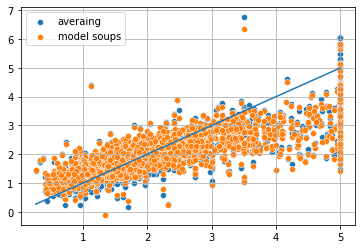

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(
    x=y_test.to_numpy(),
    y=y_test.to_numpy(),
)

sns.scatterplot(
    x=y_test.to_numpy(),
    y=y_pred,
    label="averaing"
)
sns.scatterplot(
    x=y_test.to_numpy(),
    y=y_pred_2,
    label='model soups'
)
plt.grid(True)
plt.show()